참고 사이트 : https://pysource.com/2019/06/27/yolo-object-detection-using-opencv-with-python/

https://deep-learning-study.tistory.com/299

YOLO ==> object detection을 위한 CNN 기반의 물체인식 알고리즘 

In [25]:
import cv2
import numpy as np
print(cv2.__version__)

4.1.2


알고리즘 로드

알고리즘 실행하기 위해서 세 개의 파일 필요
1. weight file : 훈련된 모델
2. cfg file : 구성파일(config 파일), 알고리즘에 관한 모든 설정이 있음
3. name file : 알고리즘이 감지할 수 있는 객체의 이름 포함하는 파일

## 네트워크 불러오기 - cv2.dnn.readNet

cv2.dnn.readNet(model, config=None, framework=None) -> retval

In [26]:
# YOLO 로드하기

net = cv2.dnn.readNet("/content/yolo/yolov3.weights", "/content/yolo/yolov3.cfg")
classes = []
with open('/content/yolo/coco.names', 'r') as f: #coco name : 80개
  classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0,255, size=(len(classes), 3))


In [27]:
#이미지 가지고 오기
img = cv2.imread('/content/yolo/room_ser.jpg')
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

네트워크에서 이미지를 바로 사용할 수 없기 때문에 먼저 이미지를 blob으로 변환

blob은 이미지에서 특징을 잡아내고 크기 조정하는 데 사용됨

YOLO가 허용하는 이미지 크기
1. 320*320 : 작고 정확도는 떨어지지만 속도는 빠름
2. 609*609 : 정확도는 더 높지만 속도는 느림
3. 416*416 : 중간

## 네트워크 입력 blob 만들기 - cv2.dnn.blobFrameImage

입력 영상을 blob 객체로 만들어서 추론 진행

주의할 점 : 인자들을 입력할 때 모델 파일이 어떻게 학습되었는지 파악하고 그에 맞게 입력해줘야함

cv2.dnn.blobFromImage(image, scalefactor=None, size=None, mean=None, swapRB=None, crop=None, ddepth=None) -> retval

## 네트워크 입력 설정하기 - cv2.dnn_Net.setInput

cv2.dnn_Net.setInput(blob, name=None, scalefactor=None, mean=None) -> None

## 네트워크 순방향 실행(추론) - cv2.dnn_Net.forward

추론을 진행할 때 사용하는 함수
네트워크를 어떻게 생성했냐에 따라 출력을 여러 개 지정 가능

In [28]:
#Object detect

blob = cv2.dnn.blobFromImage(img, 0.00392, (416,416), (0,0,0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers) # 감지 결과

In [36]:
# 정보를 화면에 표시하기

class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        # print(class_id)
        confidence = scores[class_id]
        if confidence > 0.5:  #신뢰도가 0.5이상이면 정확히 감지되었다고 판단.

            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [30]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4) #노이즈 제거

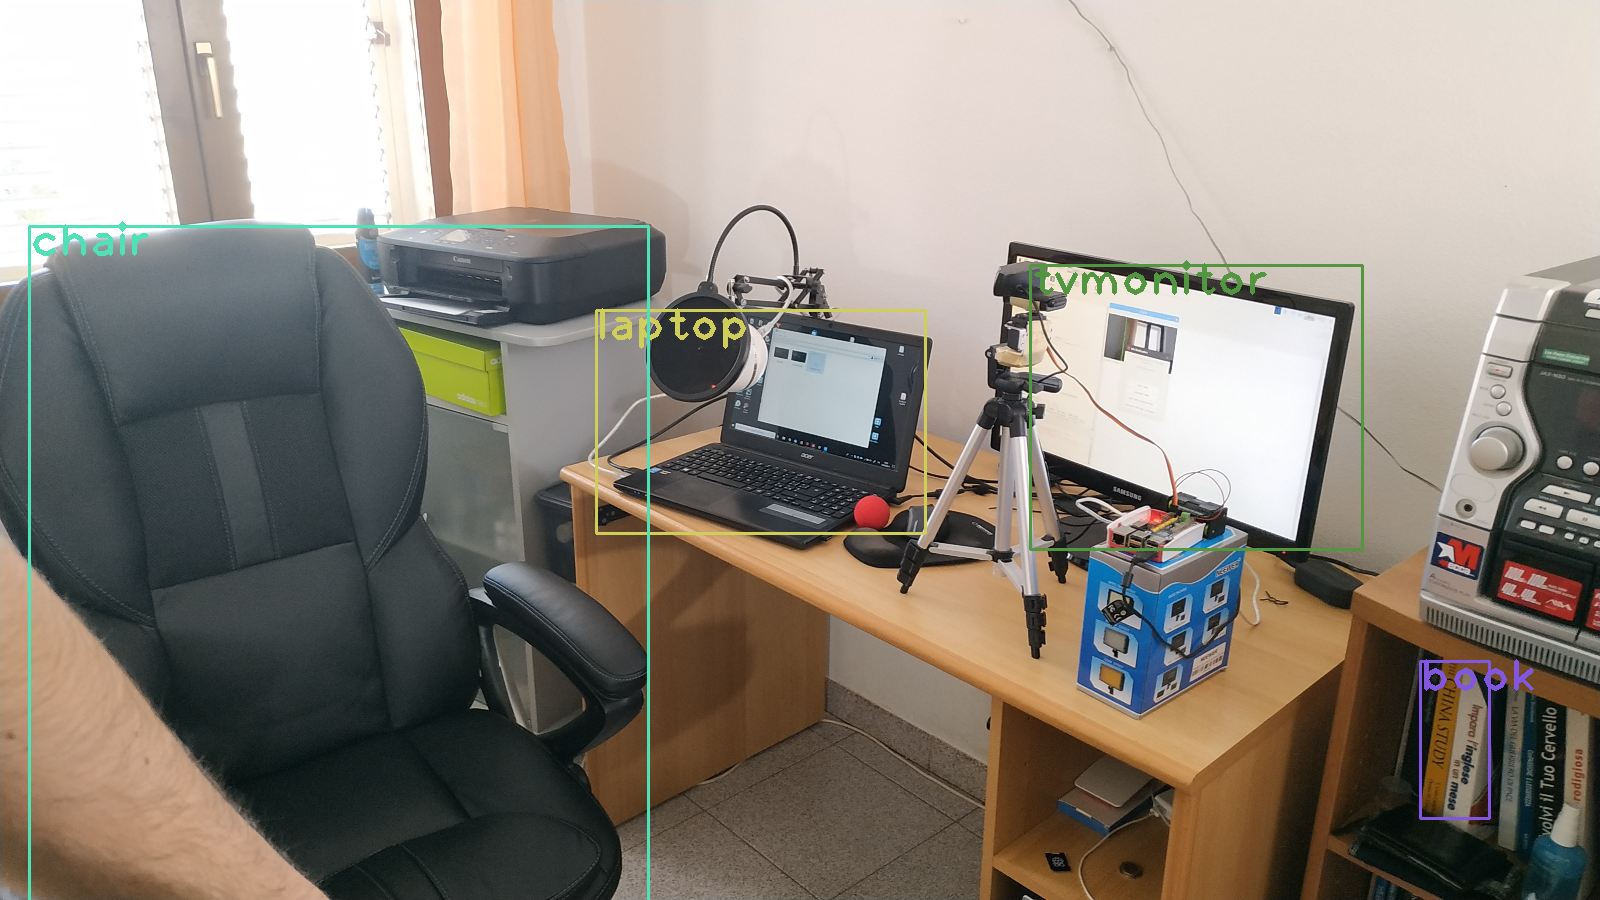

In [31]:
from google.colab.patches import cv2_imshow
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()